In [1]:
import contextily as ctx
import os,sys
import matplotlib.pyplot as plt
from pygeotools.lib import geolib,iolib,malib,warplib
import geopandas as gpd
from affine import Affine
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
from pyproj import Proj, transform
%matplotlib notebook

In [2]:
elevation_difference_fn = 'dem_align_ASTER_WV_index_2000-2018_aea_trend_3px_filt_mos_retile.tif'
gdf = gpd.read_file('fig_rough_extent.gpkg')
gdf = gdf.to_crs(rio.open(elevation_difference_fn).crs)
glac_shp = ('/home/shashank/data/rgi60/regions/rgi60_merge_HMA_aea.shp')
glac  = gpd.read_file(glac_shp)

In [3]:
gdf_extent_buf = gdf['geometry'].buffer(4000)
extent_clip = gdf.total_bounds #minx,miny,maxx,maxy 
#this is same as the format expected by gdalwarp later

In [4]:
extent_clip

array([  17264.37467913, -958262.42377205,  239532.18295829,
       -801308.69408767])

In [5]:
extent_clip[0]= extent_clip[0]-2000

In [6]:
extent_clip

array([  15264.37467913, -958262.42377205,  239532.18295829,
       -801308.69408767])

In [7]:
glac = glac.to_crs({'init':'epsg:3857'})

In [8]:
glac.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-10.02737,G091712E46821N,20130830,-9999999,91.711998,46.820732,10,4,2.589,3511,...,46,2238,0,0,0,0,9,9,None,"POLYGON ((10210762.13747199 5913158.539749358,..."
1,RGI60-10.02738,G091715E46809N,20130830,-9999999,91.715271,46.809258,10,4,0.918,3510,...,71,1727,0,0,0,0,9,9,None,"POLYGON ((10210041.82767493 5911682.735817308,..."
2,RGI60-10.02739,G091676E46825N,20130830,-9999999,91.676498,46.824841,10,4,0.166,3421,...,319,808,0,0,0,0,9,9,None,"POLYGON ((10205839.63701122 5913164.835534602,..."
3,RGI60-10.02740,G091695E46823N,20130830,-9999999,91.694595,46.822754,10,4,2.623,3228,...,11,2363,0,0,0,0,9,9,None,"POLYGON ((10208619.06773464 5914353.254582849,..."
4,RGI60-10.02741,G091690E46814N,20130830,-9999999,91.689743,46.814491,10,4,0.248,3872,...,173,661,0,0,0,0,9,9,None,"POLYGON ((10206079.75460001 5912474.895911159,..."


## clip the entire data into region

In [9]:
ds = warplib.memwarp_multi_fn([elevation_difference_fn,],extent=extent_clip)
ma = iolib.ds_getma(ds[0])

/home/shashank/softwares/github_forks/pygeotools/pygeotools/lib/warplib.py:387: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extent in extent_str_list and src_ds_list is not None:
/home/shashank/softwares/github_forks/pygeotools/pygeotools/lib/warplib.py:404: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif extent == 'source':



Warping all inputs to the following:
Resolution: 29.999999999999996
Extent: [15264.374679128152, -958262.423772053, 239532.1829582899, -801308.6940876682]
Projection: '+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 1: dem_align_ASTER_WV_index_2000-2018_aea_trend_3px_filt_mos_retile.tif
nl: 5232 ns: 7476 res: 30.000


In [10]:
outfn = os.path.splitext(elevation_difference_fn)[0]+'_fig3_extent.tif'
iolib.writeGTiff(ma,outfn,src_ds=ds[0],ndv=-9999.0)

In [11]:
ds_final = warplib.memwarp_multi_fn([outfn,],t_srs='EPSG:3857',res='30')
ma = iolib.ds_getma(ds_final[0])


Warping all inputs to the following:
Resolution: 30.0
Extent: None
Projection: '+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs'
Resampling alg: cubic

1 of 1: dem_align_ASTER_WV_index_2000-2018_aea_trend_3px_filt_mos_retile_fig3_extent.tif
nl: 6023 ns: 8623 res: 30.000


In [12]:
xmin,ymin,xmax,ymax = geolib.ds_extent(ds_final[0])
extent_fig = [xmin,xmax,ymin,ymax]

In [20]:
%matplotlib inline

In [14]:
def point_convert(row):
    geom = Point(row['lon'],row['lat'])
    return geom

In [15]:
def cax_cbar(ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return cax

In [16]:
mt_everest_coord = (86.9250,27.9881) #lon,lat or x,y
Shishapangma_coord = (85.7792,28.3525)
df_point = pd.DataFrame({'name':['Mt. Everest', 'Mt. Shishapangma'], 'lon' : [86.9250,85.7792,],'lat':[27.9881,28.3525]})
df_point['geometry'] = df_point.apply(point_convert,axis=1)
gdf_point = gpd.GeoDataFrame(df_point,geometry='geometry',crs={'init':'epsg:4326'})
gdf_point = gdf_point.to_crs({'init':'epsg:3857'})

In [17]:
x_text = gdf_point.geometry.x.values
y_text = gdf_point.geometry.y.values

In [18]:
def plot_geo_grid(ax,lat_in,lon_in,in_proj='epsg:3857'):
    """
    plot geogragriphical grid on axes with projected coordinates
    Inputs are ax object, latitude interval, longitude interval, assumed input projection is epsg:3857
    """
    X_LIM = ax.get_xlim()
    Y_LIM = ax.get_ylim()
    init_proj =Proj(init=in_proj)
    out_proj = Proj(init='epsg:4326')
    X0 = transform(init_proj,out_proj,X_LIM[0],Y_LIM[0])[0]
    x0 = np.floor(transform(init_proj,out_proj,X_LIM[0],Y_LIM[0])[0])+lon_in
    x1 = transform(init_proj,out_proj, X_LIM[1],Y_LIM[0])[0]
    Y = transform(init_proj,out_proj, X_LIM[1],Y_LIM[0])[1]
    x_list = np.arange(x0,x1,lon_in)
    x_list = sorted([i for i in x_list if i >= X0])
    transform_4326 = list(zip(x_list,[Y]*len(x_list)))
    transform_3857 = [transform(out_proj,init_proj,x[0],x[1]) for x in transform_4326]
    X_in = [x[0] for x in transform_3857]
    X_out = [np.round(x[0],2) for x in transform_4326]
    Y0 = Y
    y0 = np.floor(Y)+lat_in
    y1 = transform(init_proj,out_proj,X_LIM[0],Y_LIM[1])[1]
    X = x0
    y_list = np.arange(y0,y1,lat_in)
    y_list = sorted([i for i in y_list if i >= Y0])
    transform_4326_y = list(zip([X]*len(y_list),y_list))
    transform_3857_y = [transform(out_proj,init_proj,x[0],x[1]) for x in transform_4326_y]
    Y_in = [x[1] for x in transform_3857_y]
    Y_out = [np.round(x[1],2) for x in transform_4326_y]
    ax.set_xticks(X_in)
    ax.set_xticklabels(X_out, minor=False)
    ax.set_yticks(Y_in)
    ax.set_yticklabels(Y_out, minor=False)

    return X_in,X_out,Y_in,Y_out

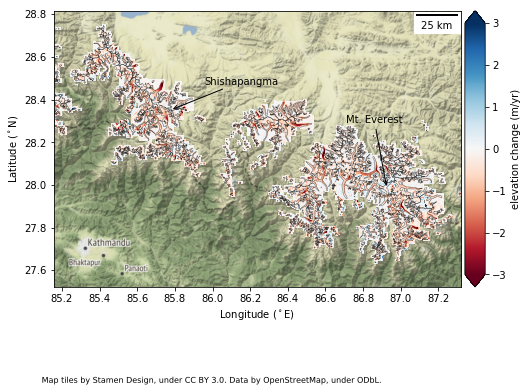

In [21]:
fig,axa = plt.subplots(figsize=(7.5,5))
im = axa.imshow(np.ma.filled(np.ma.masked_where(ma.data==0,ma.data),np.nan),clim=(-3,3),cmap='RdBu',interpolation='bilinear',extent=extent_fig,aspect='equal')
#gdf2 = gdf.geometry.buffer(-10000)
#gdf2.to_crs({'init':'epsg:3857'}).plot(ax=axa,edgecolor='None',facecolor='None')
ctx.add_basemap(axa,zorder=-1)
plt.colorbar(im,ax=axa,extend='both',cax=cax_cbar(axa),label='elevation change (m/yr)')
#gdf_point.plot(ax=axa,marker="^",c='k')
scalebar = ScaleBar(1.0)
axa.add_artist(scalebar)
#axa.set_xticks([])
#axa.set_yticks([])
x_ax_min,x_ax_max = axa.get_xlim()
y_ax_min,y_ax_max = axa.get_ylim()
fac = x_ax_min-xmin
xmax_new = xmax+fac
ymin_new =ymin-fac
ymax_new = ymax+fac
axa.set_xlim((xmin,xmax_new-9000))
axa.set_ylim((ymin_new,ymax_new))
glac.plot(ax=axa,edgecolor='k',facecolor='None',linewidth=0.5,alpha=0.6)
#axa.text(x_text[0]+1000,y_text[0]-500,'Mt. Everest')
#axa.text(x_text[1]+1000,y_text[1]-200,'Shishapangma')
plt.tight_layout()
X_in,X_out,Y_in,Y_out = plot_geo_grid(axa,0.2,0.2)
#axa.grid()
axa.set_xlabel('Longitude ($^\circ$E)')
axa.set_ylabel('Latitude ($^\circ$N)')
#axa.text(9680000,3320000,'Tibet/China',color='k',weight='bold')
#axa.text(9564000,3220000,'Nepal',color='k',weight='bold')
axa.annotate('Mt. Everest', xy=(x_text[0],y_text[0]), xytext=(x_text[0]-24000,y_text[0]+38000),
            arrowprops=dict(facecolor='black',arrowstyle="->"))
axa.annotate('Shishapangma', xy=(x_text[1],y_text[1]), xytext=(x_text[1]+20000,y_text[1]+15000),
            arrowprops=dict(facecolor='black',arrowstyle="->"))
             #arrowprops=dict(facecolor='black', shrink=0.05))
fig.savefig('Figure3_Shean_etal_HMA19_geogrid_final.jpg',fig_opt={'dpi':300, 'bbox_inches':'tight', 'pad_inches':0})
#list(axa.get_yticklabels())